In [1]:
!pip install transformers datasets torch scikit-learn

In [2]:
!pip install hyperopt

In [3]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install ray


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import ray
import torch
import pandas as pd
from torch.utils.data import Dataset
from transformers import AutoTokenizer
from datasets import load_dataset
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from train_fn import train_model
from ray.tune.search.hyperopt import HyperOptSearch

# 환경 변수 설정
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["RAY_DISABLE_DOCKER_CPU_WARNING"] = "1"

ray.init(ignore_reinit_error=True)
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import ray

# Ray 초기화 (이미 초기화되어 있으면 무시)
ray.init(ignore_reinit_error=True)

nsmc = load_dataset("e9t/nsmc", trust_remote_code=True)
train_texts = nsmc["train"]["document"]
train_labels = nsmc["train"]["label"]
test_texts = nsmc["test"]["document"]
test_labels = nsmc["test"]["label"]

# -------------------------------------
# 2. 토크나이저를 이용한 텍스트 인코딩
# -------------------------------------
model_name = "beomi/KcELECTRA-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

# -------------------------------------
# 3. 커스텀 PyTorch Dataset 정의
# -------------------------------------
class NSMCDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        # Python 3.9 이상에서는 dict union (|) 연산자를 사용할 수 있습니다.
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {"labels": torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = NSMCDataset(train_encodings, train_labels)
val_dataset = NSMCDataset(test_encodings, test_labels)

# -------------------------------------
# 4. Ray Object Store에 데이터셋 저장
# -------------------------------------
TRAIN_DATASET_REF = ray.put(train_dataset)
VAL_DATASET_REF = ray.put(val_dataset)



2025-02-13 05:49:03,160	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.
2025-02-13 05:49:03,172	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


In [6]:
pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 46.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 154.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
고정 하이퍼파라미터로 학습을 시작합니다:
{'model_name': 'beomi/KcELECTRA-base', 'lr': 4e-05, 'batch_size': 8, 'epoch': 10, 'grad_accum_steps': 4, 'patience': 2, 'weight_decay': 0.1}
[Epoch 1] Train Loss: 0.4225
[Epoch 1] Val Loss: 0.2742, Val Accuracy: 0.8874
[Epoch 2] Train Loss: 0.2582
[Epoch 2] Val Loss: 0.2533, Val Accuracy: 0.9013
[Epoch 3] Train Loss: 0.2185
[Epoch 3] Val Loss: 0.2434, Val Accuracy: 0.9037
[Epoch 4] Train Loss: 0.1825
[Epoch 4] Val Loss: 0.2353, Val Accuracy: 0.9088
[Epoch 5] Train Loss: 0.1406
[Epoch 5] Val Loss: 0.2610, Val Accuracy: 0.9077
[Epoch 6] Train Loss: 0.1085
[Epoch 6] Val Loss: 0.3148, Val Accuracy: 0.9075
Early stopping triggered!
최고 성능을 보인 모델 로드 완료!
최종 평가 결과: Loss = 0.2353, Accuracy = 0.9088
모델과 평가 결과가 저장되었습니다.


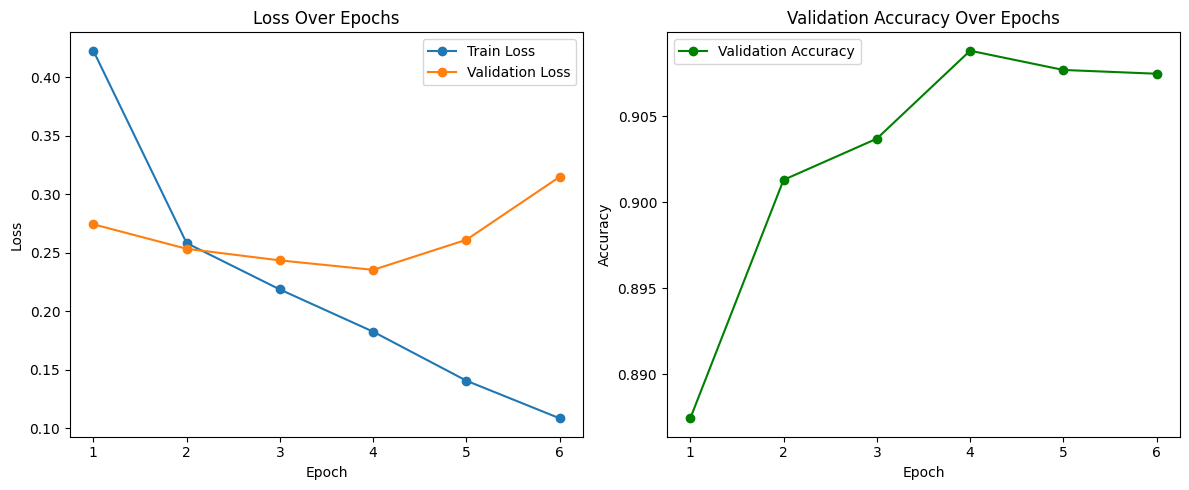

In [7]:
import json
import pickle
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def train_model(config, train_dataset, val_dataset):
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
    
    # 모델 로드
    model = AutoModelForSequenceClassification.from_pretrained(config["model_name"], num_labels=2)
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=config["lr"], weight_decay=config.get("weight_decay", 0.1))
    
    max_epochs = config.get("epoch", 10)
    total_steps = len(train_loader) * max_epochs
    warmup_steps = int(0.3 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    
    grad_accum_steps = config.get("grad_accum_steps", 4)
    best_loss = float('inf')
    patience = config.get("patience", 2)
    epochs_without_improvement = 0
    best_model_path = "best_model_new.pth"
    
    # === 결과 수집용 리스트 ===
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(max_epochs):
        model.train()
        total_loss = 0.0
        batch_count = 0
        optimizer.zero_grad()
        
        # === Train Loop ===
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / grad_accum_steps
            total_loss += loss.item() * grad_accum_steps
            loss.backward()
            batch_count += 1
            
            if batch_count % grad_accum_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
        # 남은 잔여 배치에 대한 옵티마이저 스텝
        if batch_count % grad_accum_steps != 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}")
        
        # === Validation Loop ===
        model.eval()
        total_val_loss = 0.0
        val_preds = []
        val_labels_ = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                total_val_loss += outputs.loss.item()
                
                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels_.extend(labels.cpu().numpy())
                
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_labels_, val_preds)
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"[Epoch {epoch+1}] Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # 최적 모델 저장 로직
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break
            
    # === 학습 종료 후 최적 모델 불러오기 ===
    model.load_state_dict(torch.load(best_model_path))
    print("최고 성능을 보인 모델 로드 완료!")
    
    return model, train_losses, val_losses, val_accuracies

# 고정 하이퍼파라미터 설정
fixed_config = {
    "model_name": "beomi/KcELECTRA-base",
    "lr": 4e-5,
    "batch_size": 8,
    "epoch": 10,
    "grad_accum_steps": 4,
    "patience": 2,
    "weight_decay": 0.1
}

print("고정 하이퍼파라미터로 학습을 시작합니다:")
print(fixed_config)
best_model, train_losses, val_losses, val_accuracies = train_model(fixed_config, train_dataset, val_dataset)

# -------------------------------
# 최종 평가 수행
# -------------------------------
val_loader = DataLoader(val_dataset, batch_size=fixed_config["batch_size"], shuffle=False)
total_val_loss = 0.0
val_preds = []
val_labels_ = []
best_model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        total_val_loss += outputs.loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels_.extend(labels.cpu().numpy())
avg_val_loss = total_val_loss / len(val_loader)
val_accuracy = accuracy_score(val_labels_, val_preds)
print("최종 평가 결과: Loss = {:.4f}, Accuracy = {:.4f}".format(avg_val_loss, val_accuracy))

# -------------------------------
# 모델과 평가 결과 저장
# -------------------------------
torch.save(best_model, "best_model_complete.pth")
torch.save(best_model.state_dict(), "best_model_weights.pth")
with open("best_model_pickle.pkl", "wb") as f:
    pickle.dump(best_model, f)

eval_results = {"val_loss": avg_val_loss, "val_accuracy": val_accuracy}
with open("eval_results.json", "w") as f:
    json.dump(eval_results, f, indent=4)

print("모델과 평가 결과가 저장되었습니다.")

# -------------------------------
# 그래프 시각화
# -------------------------------
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# 1) Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# 2) Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# 평가 지표 계산 (이진 분류 기준, 여기서는 긍정을 pos_label=1로 가정)
precision = precision_score(val_labels_, val_preds, pos_label=1)
recall = recall_score(val_labels_, val_preds, pos_label=1)
f1 = f1_score(val_labels_, val_preds, pos_label=1)

print("평가 지표:")
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

print("\n전체 분류 리포트:")
print(classification_report(val_labels_, val_preds, digits=4))


평가 지표:
Precision: 0.8997
Recall: 0.9217
F1 Score: 0.9105

전체 분류 리포트:
              precision    recall  f1-score   support

           0     0.9186    0.8958    0.9070     24827
           1     0.8997    0.9217    0.9105     25173

    accuracy                         0.9088     50000
   macro avg     0.9091    0.9087    0.9088     50000
weighted avg     0.9091    0.9088    0.9088     50000

